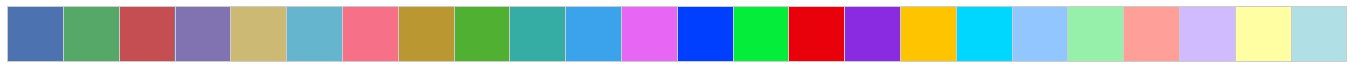

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
import warnings
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
    count_classes
)

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

In [3]:
convert_pvt_test()

TypeError: unsupported operand type(s) for +=: 'int' and 'tuple'

### Reading

In [2]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols
global_feature_importance = None
train, train_foi = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 5.07 s


In [5]:
models = [
    ('09_err_xyz_100', 0.19043), #                                 | 19213590 | 7315.29 |
    ('09_vm_100', 0.19043), #                                     | 19236776 | 7324.46 |
    ('10_wo_time_constraints_mean_100', 0.103246), #              | 19247316 | 7287.91 |
    ('11_1m_1000', 0.0867), #                                     | 19249842 | 7385.34 |
    ('12_baseline_2m_400', 0.19043), #                            | 19263823 | 7387.86 |
]

In [9]:
def get_predictions(model):
    model_name, th = model
    predictions = pd.read_csv('out/'+model_name+'.csv', index_col='id')
    return predictions

get_predictions(models[0])

,prediction
id,
0,0.488395
1,0.114578
2,0.110223
3,0.151462
4,0.444676
5,0.095534
6,0.059474
7,0.151274
8,0.110877


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [32]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import model_selection as mdsel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import scoring
from common import train_cols

def split_classes(data):
    return [data.loc[data.label == i, :] for i in range(2)]

def count_classes(data):
    cnt_0 = np.count_nonzero(data.label == 0)
    return cnt_0, len(data.index) - cnt_0

def sample(data, nrows):
    return data.iloc[np.random.permutation(len(data.index))[:nrows], :]


def fit(train, n_estimators, transformer_cls):
    labels, weights = get_labels_weights(train.loc[:, train_cols])

    # defined much later
    transformer = transformer_cls().fit(train)
    train_values = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=n_estimators, n_jobs=3)
    estimator.fit(train_values, labels, sample_weight=weights, eval_metric=scoring.rejection90_sklearn)
    return transformer, estimator
    
def predict(fitted_state, test):
    transformer, estimator = fitted_state

    test_value = transformer.transform(test)
    predictions = estimator.predict_proba(test_value)[:, 1]
    return predictions

def score(fitted_state, test):
    labels, weights = get_labels_weights(test.loc[:, train_cols])
    predictions = predict(fitted_state, test)
    return scoring.rejection90(labels, predictions, sample_weight=weights)

def fit_predict_save(train, test, filename, n_estimators, transformer_cls):
    fitted_state = fit(train, n_estimators, transformer_cls)
    predictions = predict(fitted_state, test)
    
    pd.DataFrame(data={"prediction": predictions}, index=test.index).to_csv(
        filename, index_label='id'
    )
    save_model(fitted_state[1], fitted_state[0], filename)

def fit_save_model(train, filename, n_estimators, transformer_cls):
    transformer, model = fit(train, n_estimators, transformer_cls)
    save_model(model, transformer, filename)

def cv_step(train_subset, test_subset, n_estimators, transformer_cls):
    fit_state = fit(train_subset, n_estimators, transformer_cls)
        
    labels, weights = get_labels_weights(test_subset[train_cols])
    predictions = predict(fit_state, test_subset)

    y_true = labels
    l, r, _ = scoring.get_threshold_details(y_true, predictions, sample_weight=weights)
    threshold = (l + r) / 2
    y_pred = predictions >= threshold

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, predictions)
    scr = scoring.rejection90(y_true, predictions, sample_weight=weights)
    
    scores = [acc, prec, rec, f1, roc_auc, scr, threshold]
    feature_importance = get_xgb_imp(fit_state[1], fit_state[0].features)
    return scores, feature_importance
    
def cross_validate(train, n_estimators, n_splits, n_rows, transformer_cls):
    train = sample(train, n_rows)
    results = [
        cv_step(train.iloc[train_indices, :], train.iloc[test_indices, :], n_estimators, transformer_cls)
        for i, (train_indices, test_indices) in enumerate(mdsel.KFold(n_splits=max(n_splits, 3), shuffle=True).split(train, train.label))
        if i < n_splits
    ]
    scores = [s for s, _ in results]
    feature_importance = sum([fi for _, fi in results]) / n_splits
        
    descr = pd.DataFrame(scores, columns=['acc', 'prec', 'rec', 'f1', 'roc_auc', 'scr', 'th'])
    feature_importance = feature_importance.sort_values(by='score', ascending=False)
    return descr, feature_importance

def get_labels_weights(data):
    return data.label.values, data.weight.values

def save_model(model, transformer, filename):
    model.save_model(to_model_filename(filename))
    with open(to_cols_filename(filename), 'w') as txt_file:
        str_arr = map(str, [transformer.origin_features, transformer.new_features])
        to_write = '\n\n'.join(str_arr)
        txt_file.write(to_write)

def to_model_filename(filename):
    return filename.replace('out/', 'models/').replace('.csv', '.xgb')

def to_cols_filename(filename):
    return filename.replace('out/', 'models/').replace('.csv', '.txt').replace('.xgb', '.txt')

def get_xgb_imp(model, feat_names):
    imp_vals = model.get_booster().get_fscore()
    scores = np.array([float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))])
    scores /= scores.sum()
    
    score = pd.DataFrame(data=scores, index=feat_names, columns=['score'])
    return score


In [37]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.00]
    return features

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + dxyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        add_velocity(data, features)
        
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=10, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.819000,0.890092,0.880213,0.885124,0.781061,0.767273,0.323021
std,0.001325,0.001092,0.001451,0.000356,0.007442,0.141612,0.007764
min,0.817636,0.889187,0.878571,0.884892,0.775291,0.605848,0.314157
25%,0.818359,0.889486,0.879658,0.884919,0.776861,0.715623,0.320223
50%,0.819082,0.889785,0.880744,0.884946,0.778432,0.825399,0.326290
75%,0.819682,0.890545,0.881034,0.885240,0.783946,0.847986,0.327453
max,0.820282,0.891304,0.881324,0.885534,0.789461,0.870574,0.328616


Wall time: 1.78 s


### Test theory

In [73]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=200000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.788060,0.780809,0.881382,0.828052,0.831894,0.737224,0.086723
std,0.002346,0.001948,0.002166,0.001886,0.002957,0.016519,0.002334
min,0.785700,0.778269,0.878670,0.826379,0.828253,0.716133,0.083700
25%,0.786800,0.780454,0.880829,0.826765,0.830061,0.734441,0.085177
50%,0.787750,0.780651,0.881347,0.827838,0.831992,0.734969,0.086766
75%,0.788150,0.780932,0.881347,0.828107,0.833185,0.738197,0.088889
max,0.791900,0.783736,0.884715,0.831170,0.835979,0.762381,0.089084


Wall time: 2min 13s


In [45]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=1, n_rows=400000, transformer_cls=DataTransformer)
display(df_scores.describe())

# global_feature_importance = feature_importance.copy()
# display(sum(global_feature_importance.score > .01))

,acc,prec,rec,f1,roc_auc,scr,th
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
mean,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
25%,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
50%,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
75%,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043
max,0.835271,0.906987,0.881292,0.893955,0.822298,0.789922,0.19043


31

Wall time: 1min 52s


In [38]:
global_feature_importance = feature_importance.copy()
sum(global_feature_importance.score > .01)

29

In [39]:
display(global_feature_importance)

,score
ErrMSE,0.116029
PT,0.076555
NShared,0.046651
DAngle[1],0.044258
DAngle[2],0.040670
P,0.039474
ncl[2],0.039474
MT,0.037081
NErr_Y[3],0.032297
NErr_X[0],0.028708


### Get result

In [46]:
test, test_foi = read_pub_test(used_cols)
# global_matched_hits_test = match_hits_batched(test, test_foi)

In [ ]:
%%time
_t = global_feature_importance
# global_feature_importance = None
fit_predict_save(sample(train, 2000000), test, "out/12_baseline_2m_400.csv", n_estimators=400, transformer_cls=DataTransformer)
global_feature_importance = _t

In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

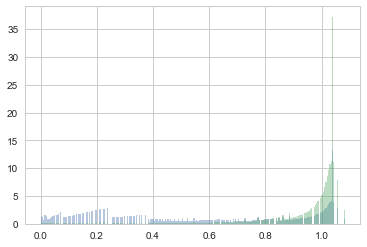

In [133]:
def plot_dll(data):
    DLL = get_dll_cdf(data, pdfs, cdfs, bins)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        _ = sns.distplot(DLL, bins=len(bins), kde=False, norm_hist=True)

dts = [dt.loc[:, err_cols[0]] for dt in split_classes(dll_train)]
plot_dll(dts[0].values)
plot_dll(dts[1].values)
# plot_dll(dll_train.loc[:, err_cols[0]].values)

In [110]:
nrows = 1000000
train, train_foi = read_train(foi_ts_cols, nrows)

ts = train_foi[foi_ts_cols[0]].values
dts = train_foi[foi_ts_cols[1]].values

DescribeResult(nobs=8637411, minmax=(1.0, 15.0), mean=6.558298, variance=11.261726, skewness=0.4544934630393982, kurtosis=-0.38207915523810065)
DescribeResult(nobs=8637411, minmax=(-14.0, 15.0), mean=2.0806417, variance=20.990376, skewness=0.5840174555778503, kurtosis=0.9575571200203767)


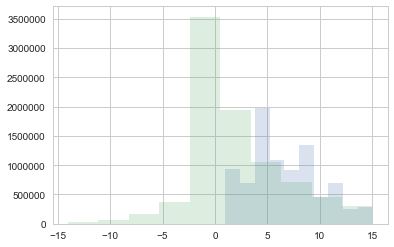

In [111]:
plt.hist(ts, alpha=0.2)
plt.hist(dts, alpha=0.2)

print(sts.describe(ts))
print(sts.describe(dts))

In [129]:
print(np.quantile(dts, (0.08, 0.8)))

[-2.  6.]
